In [1]:
using Pkg
Pkg.activate("..")
using Dao
Pkg.activate("/Users/andresouza/Desktop/OceanTurb.jl")
using OceanTurb
using BenchmarkTools
using Plots
using Distributions
using Statistics
using Random
using Base
using NetCDF
using JLD2

In [2]:
include("convenience.jl")
pathtoLES = "/Users/andresouza/Desktop/Julia/Greg_Wagner/OceanTurb.jl/examples/"
T_s ,z ,t = load_LES(30,pathtoLES);

In [3]:
params = [0.1; 0.4; 6.33; 2.0; 6.4; 0.599; 1.36; 0.5; 2.5; 4.32; 0.3; 1.0; 1.0/4; 1.0/2; 1.0/3.0; 1.0/3.0];
T_p_pre = model_run(params,4*8,36);

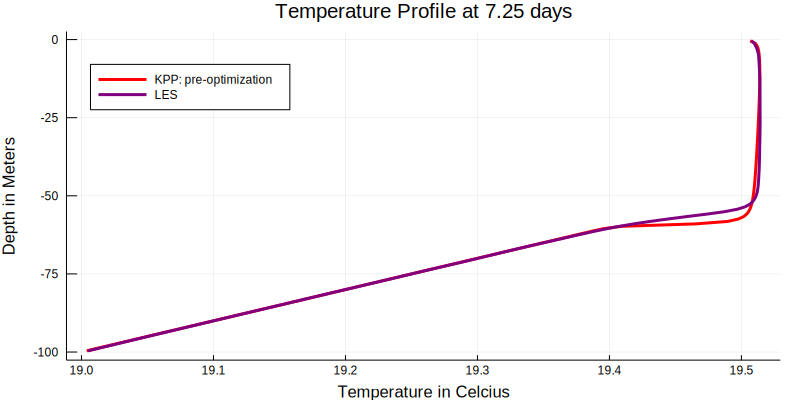

In [4]:
index = 30
plot(T_p_pre[index],z, color = "red",lw = 3, legend=:topleft,label="KPP: pre-optimization")
plot!(T_s[index],z, label="LES", title = "Temperature Profile at "*string(t[index]/86400)*" days",
    xlabel = "Temperature in Celcius", ylabel = "Depth in Meters",size = (800, 400), color = "purple",lw = 3)

In [5]:
#Builds Loss Function
ni = 4
function loss(params)
    T_p = model_run(params,ni,36);
    loss = 0
    for i in 1:(ni+1)
        loss += mean((T_p[i] .- T_s[i] ).^2 )
    end
    loss *= 1 / (ni+1)
    loss==loss ? loss = loss : loss = Inf #change to make nan checker clearer using isnan
    return loss
end
#function to keep parameters between 0 and 1
torus(x) = (x)%1 - 0.5 * (sign(x) - 1) 

#now we can define a random walk
params = [0.1; 0.4; 6.33; 2.0; 6.4; 0.599; 1.36; 0.5; 2.5; 4.32; 0.3; 1.0; 1.0/4; 1.0/2; 1.0/3.0; 1.0/3.0];
index_mod = [1 3 6 7 10 11]
sdlist = ones(length(params))
@. sdlist = abs(params[1,:])
#define a random walk
function perturbation(params)
    new_params = deepcopy(params)
    for i in index_mod
        new_params[i] += rand(Normal(0, sdlist[i]))
    end
    new_params[1]  = torus(new_params[1])
    new_params[11]  = torus(new_params[11])
    return new_params
end

perturbation (generic function with 1 method)

In [6]:
#perform MCMC
Random.seed!(1234)
params = [0.1; 0.4; 6.33; 2.0; 6.4; 0.599; 1.36; 0.5; 2.5; 4.32; 0.3; 1.0; 1.0/4; 1.0/2; 1.0/3.0; 1.0/3.0];
error_scale = 10.0
plist, vlist = markov_chain(loss, params, perturbation, error_scale, 1000);

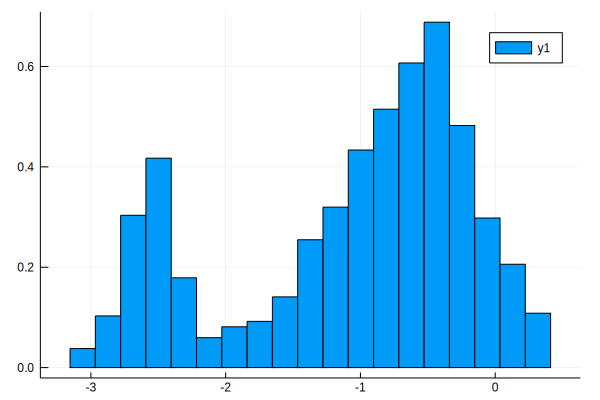

In [7]:
#=
CSL   :: 1  # Surface layer fraction
Cτ    :: 2  # Von Karman constant
CNL   :: 3  # Non-local flux proportionality constant
Cstab :: 4  # Stable buoyancy flux parameter for wind-driven turbulence
Cunst :: 5  # Unstable buoyancy flux parameter for wind-driven turbulence
Cb_U  :: 6  # Buoyancy flux parameter for convective turbulence
Cτb_U :: skip  # Wind stress parameter for convective turbulence
Cb_T  :: 7  # Buoyancy flux parameter for convective turbulence
Cτb_T :: skip  # Wind stress parameter for convective turbulence
Cd_U  :: 8  # Wind mixing regime threshold for momentum
Cd_T  :: 9  # Wind mixing regime threshold for tracers
CRi   :: 10  # Critical bulk Richardson number
CKE   :: 11  # Unresolved turbulence parameter
CKE₀  :: skip  # Minimum unresolved turbulence kinetic energy
Cn    :: 12  # Exponent for effect of stable buoyancy forcing on wind mixing
Cmτ_U :: 13  # Exponent for effect of unstable buoyancy forcing on wind mixing of U
Cmτ_T :: 14  # Exponent for effect of unstable buoyancy forcing on wind mixing of T
Cmb_U :: 15  # Exponent for effect of wind on convective mixing of U
Cmb_T :: 16  # Exponent for effect of wind on convective mixing of T
KU₀   :: skip  # Interior viscosity for velocity
KT₀   :: skip  # Interior diffusivity for temperature
KS₀   :: skip  # Interior diffusivity for salinity
=#
#[1 3 6 7 10 11]
ind = 6
range = 1:1000
min_p1 = minimum(plist[ind,range])
max_p1 = maximum(plist[ind,range])
dsp1 = (max_p1 - min_p1) / 20
bins = collect(min_p1:dsp1:max_p1)
p1 = histogram(plist[ind,range],normalize=true,bins = bins)

In [8]:
#find the best parameters
minv = minimum(vlist)
println("minimum loss")
println(minv)
println("original loss")
println(vlist[1])
best_p = plist[:,argmin(vlist)]
println("best parameters")
println(best_p)
println("orignal parameters")
println(plist[:,1])

minimum loss
4.4222915557231276e-7
original loss
8.84745083526292e-7
best parameters
[0.0669403, 0.4, 5.1062, 2.0, 6.4, -0.693989, 1.43679, 0.5, 2.5, 6.06292, 0.183709, 1.0, 0.25, 0.5, 0.333333, 0.333333]
orignal parameters
[0.1, 0.4, 6.33, 2.0, 6.4, 0.599, 1.36, 0.5, 2.5, 4.32, 0.3, 1.0, 0.25, 0.5, 0.333333, 0.333333]


In [9]:
params = best_p
T_p = model_run(params,4*8,36);

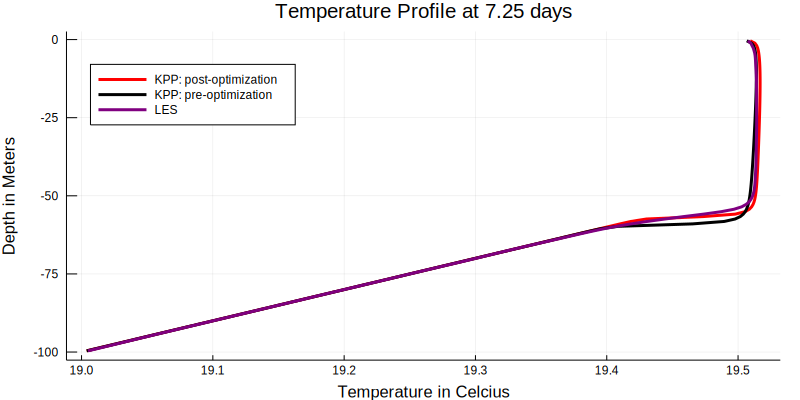

In [10]:
index = 30
plot(T_p[index],z, color = "red",lw = 3, legend=:topleft,label="KPP: post-optimization")
plot!(T_p_pre[index],z, color = "black",lw = 3, legend=:topleft,label="KPP: pre-optimization")
plot!(T_s[index],z, label="LES", title = "Temperature Profile at "*string(t[index]/86400)*" days",
    xlabel = "Temperature in Celcius", ylabel = "Depth in Meters",size = (800, 400), color = "purple",lw = 3)

In [11]:
#seems to do well
params =   [0.08839877407397116; 
    0.4; 
    4.013929636337042; 
    2.0; 
    6.4; 
    -2.8716489099897435 ;
    0.9038473081542814 ; 
    0.5;
    2.5 ;
    4.907014533378782;
    0.21558294163439823;
  1.0                ;
  0.25               ;
  0.5                ;
  0.3333333333333333 ;
  0.3333333333333333] 
loss(params)

4.1604677352394993e-7

In [12]:
@btime markov_chain(loss, params, perturbation, error_scale, 10);

  759.068 ms (19401921 allocations: 334.02 MiB)


In [13]:
@btime loss(params)

  65.485 ms (1762275 allocations: 30.34 MiB)


4.1604677352394993e-7